# Bragg reflector

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import hilbert
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

import scipy.constants
import math

from IPython.display import clear_output

import os
import fnmatch
import imageio

## Design of the optical circuit

Design of the geometry of the optical component and set the simulation parameters.

### Solution with different width for the two layers

The condition of constructive interference between the reflected rays of each layer is given by

$n_1 L_1 = \frac{\lambda}{4} \qquad n_2 L_2 = \frac{\lambda}{4}$ &nbsp;&nbsp;&nbsp;&nbsp; or &nbsp;&nbsp;&nbsp;&nbsp; $L (n_1 + n_2) = \frac{\lambda}{2}$

In [2]:
# if plain is True no image will be saved during the simulation
plain = True
# give that plain is False, if animation is True the simulation will produce an .mp4 animation, otherwise it will produce .gif animation
animation = False

In [3]:
x_dim = 22
y_dim = 8
PML_thick = 1
resolution = 16

n_1 = 1.5 # silica
n_2 = 2.5 # titanium dioxide

layers=10
wavelenght = 1.55

grat_period_1 = round(wavelenght / 4 / n_1, 2)
grat_period_2 = round(wavelenght / 4 / n_2, 2)
grat_height = y_dim

print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
        {grat_period_1} um for the n = {n_1} material
        {grat_period_2} um for the n = {n_2} material\n''')

source_width = 6

fcen = 1 / wavelenght
df = 0.5*fcen
nfreq = 1000

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

for norma in [False, True]:
    geometry=[]
    if norma:
        sim.reset_meep()
        geometry = [mp.Block(
                        mp.Vector3((grat_period_1 + grat_period_2)*layers, grat_height,0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        for ii in range(-int(layers/2), int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + grat_period_2/2, 0, 0),
                            material = mp.Medium(index=n_2))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    if (not plain):
        f = plt.figure(dpi=600)
        animate = mp.Animate2D(sim, mp.Ez, f=f)
        plt.close()

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    
    if norma:
        sim.load_minus_flux_data(refl, straight_refl_data)
        if (plain):
            sim.run(until_after_sources = 400)
            # sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        else:
            if (animation):
                sim.run(mp.at_every(2, animate),
                        until_after_sources = 400)
                        # until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
                animate.to_mp4(15, './BraggRifractor.mp4')
            else:
                sim.run(mp.at_every(2, animate),
                        until_after_sources = 400)
                        # until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
                animate.to_gif(15, './BraggRifractor.gif')
    else:
        sim.run(until_after_sources = 400)
        # sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        
    if norma:
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    else:
        straight_refl_data = sim.get_flux_data(refl) # get_flux_data create a binary obj that can't used for inverstigation
        straight_tran_flux = mp.get_fluxes(tran)

The period of the grating for a wavelenght of 1.55 nm are:
        0.26 um for the n = 1.5 material
        0.15 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000349045 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
time for set_epsilon = 0.104366 s
-----------


FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 213.25/431.0 = 49.5% done in 4.0s, 4.1s to go
on time step 6840 (time=213.75), 0.000585057 s/step
Meep progress: 403.9375/431.0 = 93.7% done in 8.0s, 0.5s to go
on time step 12942 (time=404.438), 0.000655613 s/step
run 0 finished at t = 431.0 (13792 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000555038 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.1,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.975,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.565,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.155,0,0)
          size (0.15,8,0)
       

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 187.78125/431.0 = 43.6% done in 4.0s, 5.2s to go
on time step 6029 (time=188.406), 0.000663509 s/step
Meep progress: 371.71875/431.0 = 86.2% done in 8.0s, 1.3s to go
on time step 11912 (time=372.25), 0.000680059 s/step
run 0 finished at t = 431.0 (13792 timesteps)


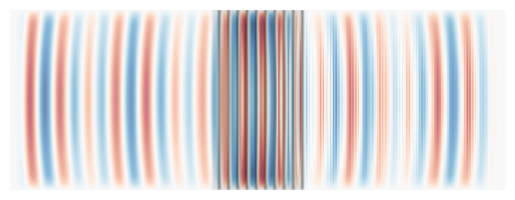

In [4]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)

plt.figure()

plt.imshow(np.flipud(np.fliplr(eps_data.transpose())), interpolation='spline36', cmap='binary')
plt.imshow(np.flipud(np.fliplr(ez_data.transpose())), interpolation='spline36', cmap='RdBu', alpha=0.6)

plt.axis('off')
plt.show()

Plot the trasmission and reflection due to the DBR.

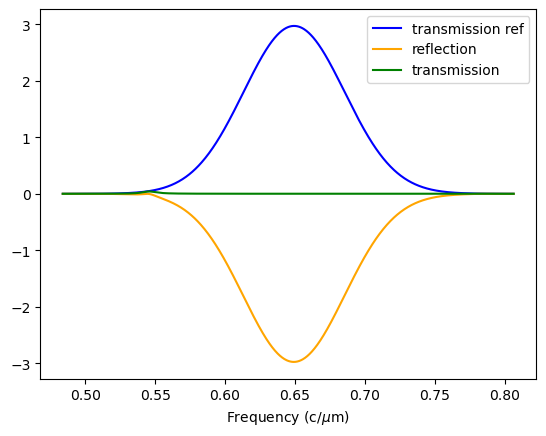

In [5]:
freqs = mp.get_flux_freqs(refl)

plt.figure()

plt.plot(freqs, straight_tran_flux, label='transmission ref', color='blue')
plt.plot(freqs, scatt_refl_flux, label='reflection', color='orange')
plt.plot(freqs, scatt_tran_flux, label='transmission', color='green')

plt.xlabel('Frequency (c/$\mu$m)')

plt.legend(loc="upper right")
plt.show()

The band width of Ts is 71.635 THz
The minimum of the band of Ts is -37.14557
band center = 198.884 THz


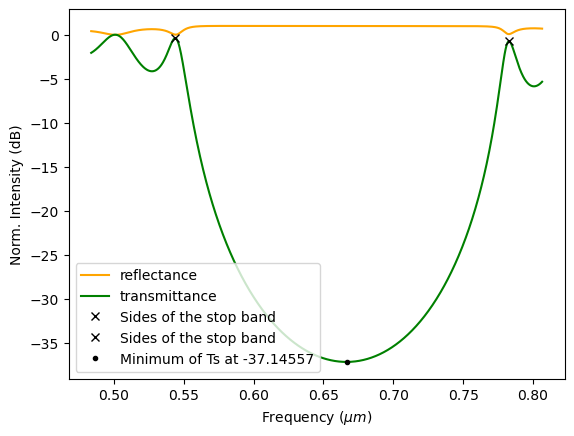

In [6]:
Rs = -np.array(scatt_refl_flux)/np.array(straight_tran_flux) # il segno è legato all'orientazione del detector
Ts = np.array(scatt_tran_flux)/np.array(straight_tran_flux)
Ts = 10*np.log10(Ts) # in dB

peak_T, _ = find_peaks(Ts, prominence=3)
peak_T_min, _ = find_peaks(-Ts, prominence=5)

plt.plot(freqs, Rs, label='reflectance', color='orange')
plt.plot(freqs, Ts, label='transmittance', color='green')
# plt.plot(wl, 1-Rs-Ts, label='loss', color='violet')

for pp in peak_T:
    plt.plot(freqs[pp], Ts[pp], "x", color='black', label='Sides of the stop band')

for pp in peak_T_min:
    plt.plot(freqs[pp], Ts[pp], ".", color='black', label=f'Minimum of Ts at {round(Ts[peak_T_min[0]], 5)}')

dw_T = ( freqs[peak_T[1]] -  freqs[peak_T[0]] ) * scipy.constants.c / 10**6
print(f'The band width of Ts is %.3f THz' % dw_T)
print(f'The minimum of the band of Ts is %.5f' % Ts[peak_T_min][0])
w0 = ( freqs[peak_T[1]] + freqs[peak_T[0]] ) / 2 * scipy.constants.c / 10**6
print('band center = %.3f THz' % w0)

plt.xlabel('Frequency ($\mu m$)')
plt.ylabel('Norm. Intensity (dB)')

# plt.yscale("log") # when the intensity isn't in dB

plt.legend(loc='lower left')
plt.show()


### Show that the central frequency of the band is efficiently refracted by the DBR

An animation is provided

     block, center = (0,0,0)
          size (4.1,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.975,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.565,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.155,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.745,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.335,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
    

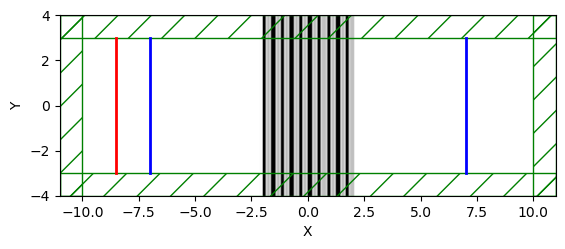

In [7]:
layers=10
wavelenght = 1.55

grat_period_1 = round(wavelenght / 4 / n_1, 2)
grat_period_2 = round(wavelenght / 4 / n_2, 2)
grat_height = y_dim

print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
        {grat_period_1} um for the n = {n_1} material
        {grat_period_2} um for the n = {n_2} material\n''')

source_width = 6

fcen = 1 / wavelenght
df = 0.5*fcen
nfreq = 1000

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

for norma in [False, True]:
    geometry=[]
    if norma:
        sim.reset_meep()
        geometry = [mp.Block(
                        mp.Vector3((grat_period_1 + grat_period_2)*layers, grat_height,0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        for ii in range(-int(layers/2), int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + grat_period_2/2, 0, 0),
                            material = mp.Medium(index=n_2))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )
    
    f = plt.figure(dpi=600)
    animate = mp.Animate2D(sim, mp.Ez, f=f)
    plt.close()

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    if norma:
        sim.load_minus_flux_data(refl, straight_refl_data)
        sim.run(mp.at_every(2, animate),
                until=3*x_dim)
        animate.to_mp4(15, './DBRMirror.mp4')
    else:
        sim.run(until=3*x_dim)
        
    if norma:
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    else:
        straight_refl_data = sim.get_flux_data(refl)
        straight_tran_flux = mp.get_fluxes(tran)

    clear_output()
    sim.plot2D()
    plt.show()

### Solution with same width for all the layers

     block, center = (0,0,0)
          size (3.875,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.84062,0,0)
          size (0.19375,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.45312,0,0)
          size (0.19375,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.06563,0,0)
          size (0.19375,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.678125,0,0)
          size (0.19375,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.290625,0,0)
          size (0.19375,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon dia

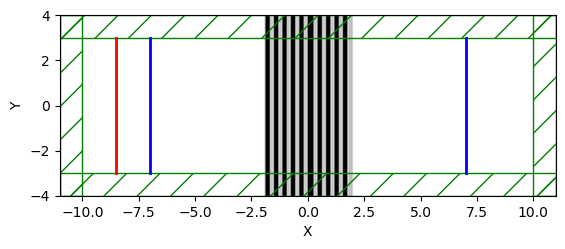

In [8]:
wavelenght = 1.55
grat_period = round(wavelenght / 2 / (n_1 + n_2), 5)
grat_height = y_dim
print(f'\n\nThe period of the grating for a wavelenght of {wavelenght} nm is {grat_period} um\n\n')

source_width = 6

fcen = 1 / wavelenght
df = 0.5*fcen
nfreq = 5000

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

for norma in [False, True]:
    geometry=[]
    if norma:
        sim.reset_meep()
        geometry = [mp.Block(
                        mp.Vector3(grat_period*layers*2, grat_height,0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        for ii in range(-int(layers/2), int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period, grat_height, 0),
                            center= mp.Vector3((2*ii+0.5)*grat_period, 0, 0),
                            material = mp.Medium(index=n_2))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0), # sempre meglio non mettere le sorgenti sulle interfacce
                                # interfaccia sx + PML + margine
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )
    
    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )


    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    if norma:
        sim.load_minus_flux_data(refl, straight_refl_data)
        sim.run(until_after_sources = 400)
        # sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
    else:
        sim.run(until_after_sources = 400)
        # sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))

    # extraction of fluxes 
    if norma:
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    else:
        straight_refl_data = sim.get_flux_data(refl) # get_flux_data create a binary obj that can't used for inverstigation
        straight_tran_flux = mp.get_fluxes(tran)

    clear_output()
    sim.plot2D()
    plt.show()

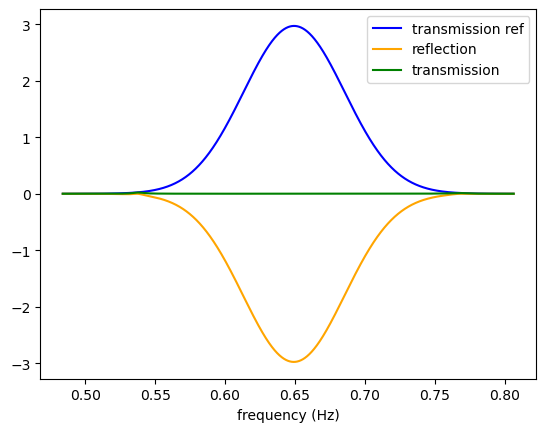

In [9]:
freqs = mp.get_flux_freqs(refl)    

plt.figure()

plt.plot(freqs, straight_tran_flux, label='transmission ref', color='blue')
plt.plot(freqs, scatt_refl_flux, label='reflection', color='orange')
plt.plot(freqs, scatt_tran_flux, label='transmission', color='green')

plt.xlabel('frequency (Hz)')

plt.legend(loc="upper right")
plt.show()

The band width of Ts is 69.856 THz
The minimum of the band of Ts is -37.09418
band center = 195.813 THz


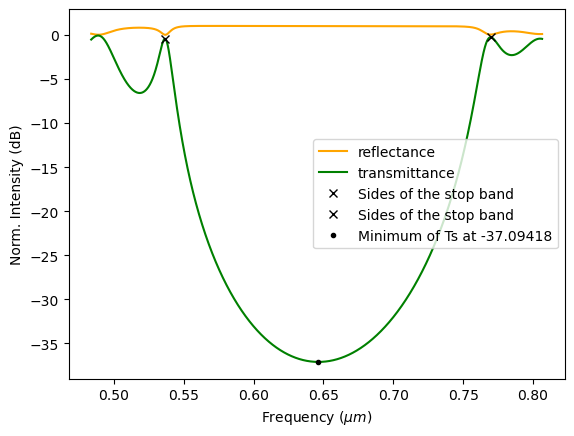

In [10]:
Rs = -np.array(scatt_refl_flux)/np.array(straight_tran_flux) # il segno è legato all'orientazione del detector
Ts = np.array(scatt_tran_flux)/np.array(straight_tran_flux)
Ts = 10*np.log10(Ts) # in dB

peak_T, _ = find_peaks(Ts, prominence=2)
peak_T_min, _ = find_peaks(-Ts, prominence=8)

plt.plot(freqs, Rs, label='reflectance', color='orange')
plt.plot(freqs, Ts, label='transmittance', color='green')
# plt.plot(wl, 1-Rs-Ts, label='loss', color='violet')

for pp in peak_T:
    plt.plot(freqs[pp], Ts[pp], "x", color='black', label='Sides of the stop band')

for pp in peak_T_min:
    plt.plot(freqs[pp], Ts[pp], ".", color='black', label=f'Minimum of Ts at {round(Ts[peak_T_min[0]], 5)}')

dw_T = ( freqs[peak_T[1]] -  freqs[peak_T[0]] ) * scipy.constants.c / 10**6
print(f'The band width of Ts is %.3f THz' % dw_T)
print(f'The minimum of the band of Ts is %.5f' % Ts[peak_T_min][0])
w0 = ( freqs[peak_T[1]] + freqs[peak_T[0]] ) / 2 * scipy.constants.c / 10**6
print('band center = %.3f THz' % w0)

plt.xlabel('Frequency ($\mu m$)')
plt.ylabel('Norm. Intensity (dB)')

# plt.yscale("log") when the intensity isn't in dB

plt.legend(loc='center right')
plt.show()


## Dependence of the stop band from the refractive indexes contrast

-----------
Initializing structure...
time for choose_chunkdivision = 0.000313044 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
time for set_epsilon = 0.112149 s
-----------


FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 115.8125/431.0 = 26.9% done in 4.0s, 10.9s to go
on time step 3708 (time=115.875), 0.00108061 s/step
Meep progress: 233.625/431.0 = 54.2% done in 8.0s, 6.8s to go
on time step 7488 (time=234), 0.0010589 s/step
Meep progress: 349.875/431.0 = 81.2% done in 12.0s, 2.8s to go
on time step 11214 (time=350.438), 0.00107539 s/step
run 0 finished at t = 431.0 (13792 timesteps)
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.22 um for the n = 1.8 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000429153 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.8,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.29,0,0)
          size (0.22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon di

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 116.4375/431.0 = 27.0% done in 4.0s, 10.8s to go
on time step 3726 (time=116.438), 0.00107477 s/step
Meep progress: 231.71875/431.0 = 53.8% done in 8.0s, 6.9s to go
on time step 7416 (time=231.75), 0.00108713 s/step
Meep progress: 347.78125/431.0 = 80.7% done in 12.0s, 2.9s to go
on time step 11142 (time=348.188), 0.00107554 s/step
run 0 finished at t = 431.0 (13792 timesteps)


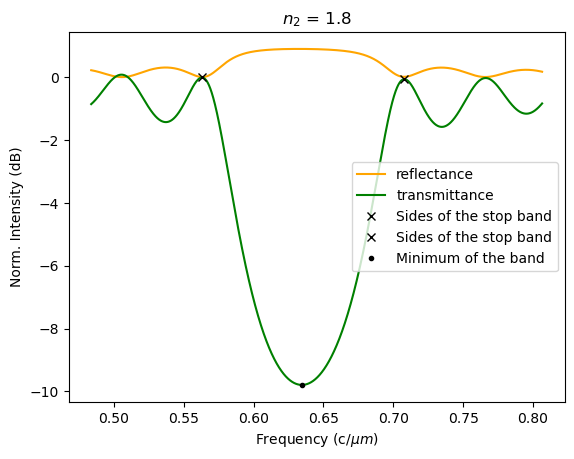

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.2 um for the n = 1.9 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000447989 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.6,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.2,0,0)
          size (0.2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-1.74,0,0)
          size (0.2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-1.28,0,0)
          size (0.2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-0.82,0,0)
 

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 113.1875/431.0 = 26.3% done in 4.0s, 11.2s to go
on time step 3633 (time=113.531), 0.00110107 s/step
Meep progress: 226.125/431.0 = 52.5% done in 8.0s, 7.3s to go
on time step 7239 (time=226.219), 0.00110931 s/step
Meep progress: 339.75/431.0 = 78.8% done in 12.0s, 3.2s to go
on time step 10874 (time=339.812), 0.00110047 s/step
run 0 finished at t = 431.0 (13792 timesteps)


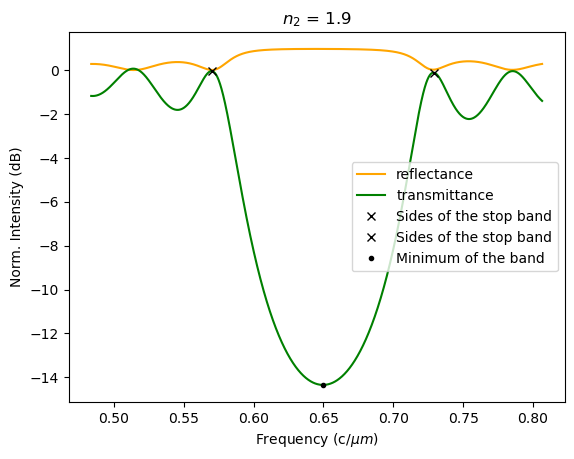

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.19 um for the n = 2.0 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000431061 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.5,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.155,0,0)
          size (0.19,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     block, center = (-1.705,0,0)
          size (0.19,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     block, center = (-1.255,0,0)
          size (0.19,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     block, center = (-0.805,0,0)
          size (0.1

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 111.625/431.0 = 25.9% done in 4.0s, 11.4s to go
on time step 3582 (time=111.938), 0.00111989 s/step
Meep progress: 225.34375/431.0 = 52.3% done in 8.0s, 7.3s to go
on time step 7220 (time=225.625), 0.00109959 s/step
Meep progress: 340.1875/431.0 = 78.9% done in 12.0s, 3.2s to go
on time step 10903 (time=340.719), 0.00108612 s/step
run 0 finished at t = 431.0 (13792 timesteps)


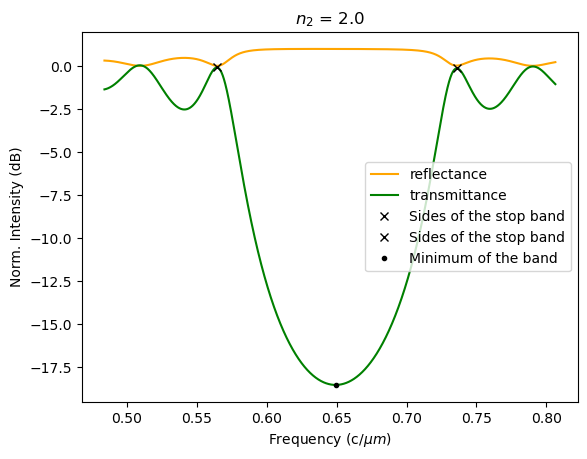

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.18 um for the n = 2.1 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.00068903 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.4,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.11,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.41,4.41,4.41)
     block, center = (-1.67,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.41,4.41,4.41)
     block, center = (-1.23,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.41,4.41,4.41)
     block, center = (-0.79,0,

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 112.1875/431.0 = 26.0% done in 4.0s, 11.4s to go
on time step 3593 (time=112.281), 0.00111331 s/step
Meep progress: 222.75/431.0 = 51.7% done in 8.0s, 7.5s to go
on time step 7135 (time=222.969), 0.00112941 s/step
Meep progress: 335.8125/431.0 = 77.9% done in 12.0s, 3.4s to go
on time step 10746 (time=335.812), 0.00110959 s/step
run 0 finished at t = 431.0 (13792 timesteps)


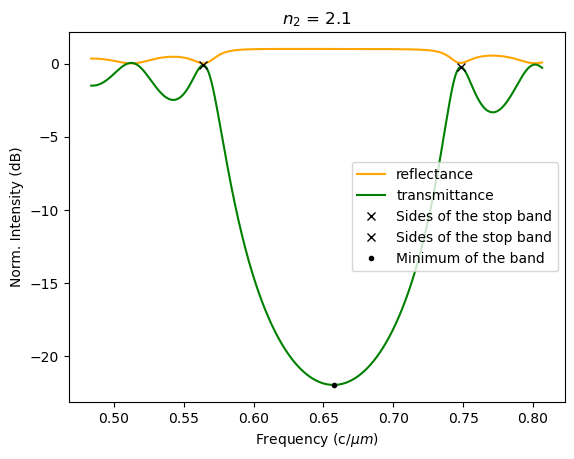

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.18 um for the n = 2.2 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000452042 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.4,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.11,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.84,4.84,4.84)
     block, center = (-1.67,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.84,4.84,4.84)
     block, center = (-1.23,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.84,4.84,4.84)
     block, center = (-0.79,0

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 110.8125/431.0 = 25.7% done in 4.0s, 11.6s to go
on time step 3564 (time=111.375), 0.00112491 s/step
Meep progress: 225.4375/431.0 = 52.3% done in 8.0s, 7.3s to go
on time step 7236 (time=226.125), 0.00109259 s/step
Meep progress: 337.5/431.0 = 78.3% done in 12.0s, 3.3s to go
on time step 10830 (time=338.438), 0.00111306 s/step
run 0 finished at t = 431.0 (13792 timesteps)


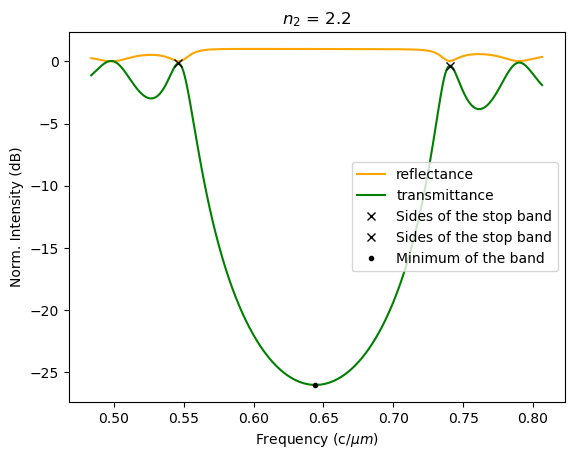

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.17 um for the n = 2.3 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000421047 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.3,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.065,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.29,5.29,5.29)
     block, center = (-1.635,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.29,5.29,5.29)
     block, center = (-1.205,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.29,5.29,5.29)
     block, center = (-0.7

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 110.8125/431.0 = 25.7% done in 4.0s, 11.6s to go
on time step 3564 (time=111.375), 0.00112511 s/step
Meep progress: 224.3125/431.0 = 52.0% done in 8.0s, 7.4s to go
on time step 7198 (time=224.938), 0.00110078 s/step
Meep progress: 335.375/431.0 = 77.8% done in 12.0s, 3.4s to go
on time step 10753 (time=336.031), 0.00112536 s/step
run 0 finished at t = 431.0 (13792 timesteps)


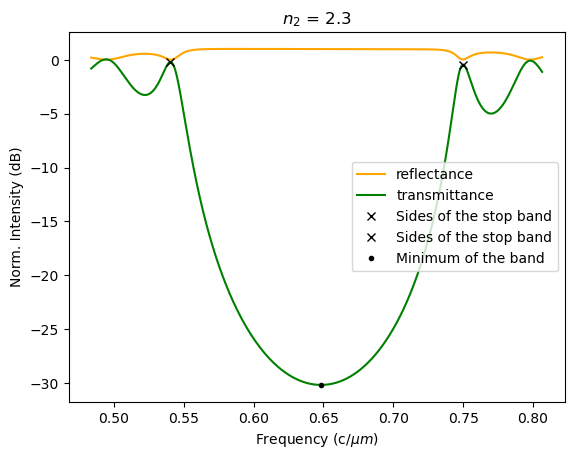

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.16 um for the n = 2.4 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.0004282 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.02,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (-1.6,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (-1.18,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (-0.76,0,0)

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 110.8125/431.0 = 25.7% done in 4.0s, 11.6s to go
on time step 3561 (time=111.281), 0.00112332 s/step
Meep progress: 223.125/431.0 = 51.8% done in 8.0s, 7.5s to go
on time step 7146 (time=223.312), 0.00111711 s/step
Meep progress: 334.6875/431.0 = 77.7% done in 12.0s, 3.5s to go
on time step 10728 (time=335.25), 0.00111939 s/step
run 0 finished at t = 431.0 (13792 timesteps)


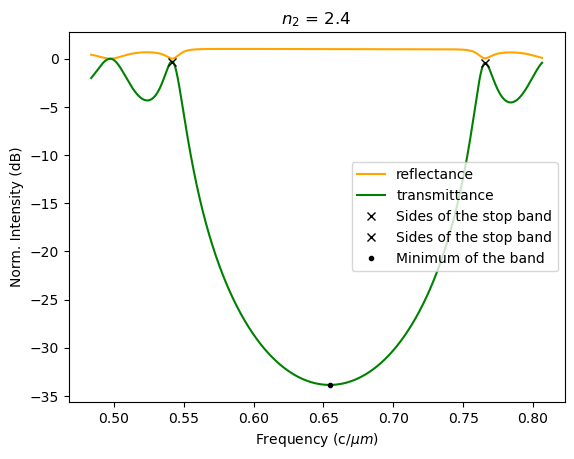

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.16 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000487089 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.02,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.6,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.18,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.76,0,

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 109.6875/431.0 = 25.4% done in 4.0s, 11.7s to go
on time step 3520 (time=110), 0.00113644 s/step
Meep progress: 221.03125/431.0 = 51.3% done in 8.0s, 7.6s to go
on time step 7074 (time=221.062), 0.00112712 s/step
Meep progress: 331.0/431.0 = 76.8% done in 12.0s, 3.6s to go
on time step 10602 (time=331.312), 0.00113463 s/step
run 0 finished at t = 431.0 (13792 timesteps)


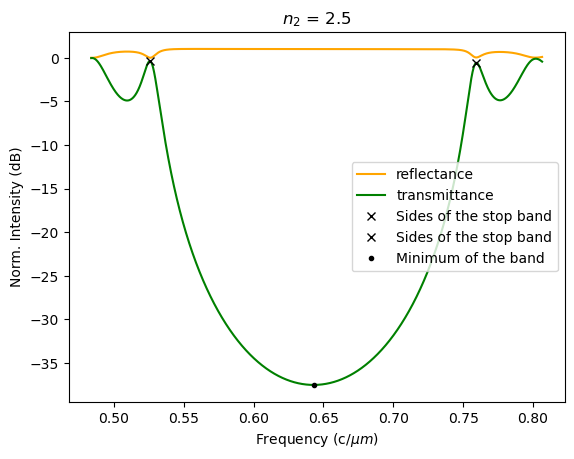

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.15 um for the n = 2.6 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000488043 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4.1,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.975,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     block, center = (-1.565,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     block, center = (-1.155,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.76,6.76,6.76)
     block, center = (-0.7

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 111.375/431.0 = 25.8% done in 4.0s, 11.5s to go
on time step 3582 (time=111.938), 0.00111754 s/step
Meep progress: 219.9375/431.0 = 51.0% done in 8.0s, 7.7s to go
on time step 7056 (time=220.5), 0.00115291 s/step
Meep progress: 333.5625/431.0 = 77.4% done in 12.0s, 3.5s to go
on time step 10695 (time=334.219), 0.00109928 s/step
run 0 finished at t = 431.0 (13792 timesteps)


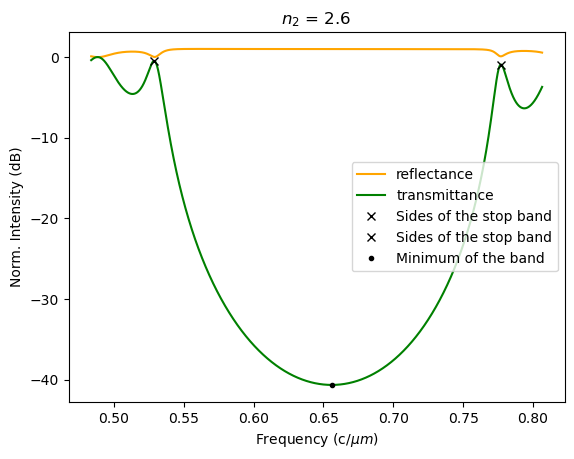

The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.14 um for the n = 2.7 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000427008 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 16
     block, center = (0,0,0)
          size (4,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.93,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.29,7.29,7.29)
     block, center = (-1.53,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.29,7.29,7.29)
     block, center = (-1.13,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.29,7.29,7.29)
     block, center = (-0.73,0,0

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 110.8125/431.0 = 25.7% done in 4.0s, 11.6s to go
on time step 3546 (time=110.812), 0.00112835 s/step
Meep progress: 226.28125/431.0 = 52.5% done in 8.0s, 7.2s to go
on time step 7244 (time=226.375), 0.00108168 s/step
Meep progress: 338.0625/431.0 = 78.4% done in 12.0s, 3.3s to go
on time step 10818 (time=338.062), 0.00112005 s/step
run 0 finished at t = 431.0 (13792 timesteps)


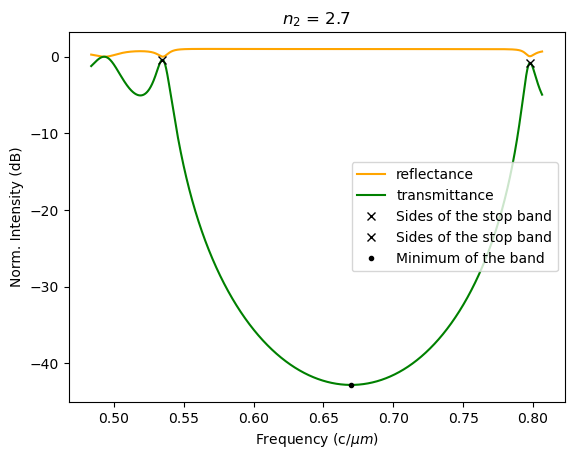

In [11]:
ref_index = []
band_width = []
attenuation = []

plot=True

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

geometry=[]
source = [mp.Source(
    mp.GaussianSource(fcen,fwidth=df),
    center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
    component=mp.Ez,
    size=mp.Vector3(0,source_width,0)
    )]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    resolution=resolution
)

# monitor
trans_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
            )
refl_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
            )

tran = sim.add_flux(fcen, df, nfreq, trans_fr)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

sim.run(until_after_sources = 400)
# sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))

straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

for ind in np.arange(1.8, 2.8, 0.1):
    ind = np.round(ind, 3)
    grat_period_1 = round(wavelenght / 4 / n_1, 2)
    grat_period_2 = round(wavelenght / 4 / ind, 2)
    
    print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
            {grat_period_1} um for the n = {n_1} material
            {grat_period_2} um for the n = {ind} material\n''')

    sim.reset_meep()
    geometry = [mp.Block(
                    mp.Vector3((grat_period_1 + grat_period_2)*layers, grat_height,0),
                    center = mp.Vector3(0,0,0),
                    material = mp.Medium(index=n_1)),
                ]
    for ii in range(-int(layers/2), int(layers/2)):
        geometry += [mp.Block(
                        mp.Vector3(grat_period_2, grat_height, 0),
                        center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + grat_period_2/2, 0, 0),
                        material = mp.Medium(index=ind))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    # sim.plot2D()
    # plt.show()

    sim.load_minus_flux_data(refl, straight_refl_data)
    sim.run(until_after_sources = 400)
    # sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
    
    scatt_refl_flux = mp.get_fluxes(refl)
    scatt_tran_flux = mp.get_fluxes(tran)
    freqs = mp.get_flux_freqs(refl)    

    Rs = -np.array(scatt_refl_flux)/np.array(straight_tran_flux)
    Ts = np.array(scatt_tran_flux)/np.array(straight_tran_flux)
    Ts = 10*np.log10(Ts) # in dB

    peak_T, _ = find_peaks(Ts, prominence=(1.4 if ind < 2 else 2.1))
    peak_T_min, _ = find_peaks(-Ts, prominence=5)

    if (plot):
        plt.plot(freqs, Rs, label='reflectance', color='orange')
        plt.plot(freqs, Ts, label='transmittance', color='green')
        # plt.plot(freqs, 1-Rs-Ts, label='loss', color='violet')
        for pp in peak_T:
            plt.plot(freqs[pp], Ts[pp], "x", color='black', label='Sides of the stop band')
        for pp in peak_T_min:
            plt.plot(freqs[pp], Ts[pp], ".", color='black', label='Minimum of the band')

        plt.xlabel('Frequency (c/$\mu m$)')
        plt.ylabel('Norm. Intensity (dB)')

        plt.title(f'$n_2$ = {ind}')
        # plt.yscale("log")
        plt.legend(loc='center right')
        plt.show()


    dw_T = ( freqs[peak_T[1]] - freqs[peak_T[0]] ) * scipy.constants.c / 10**6 # THz
    T_min = Ts[peak_T_min[0]]
    
    # print(f'The band width of Ts is {round(dw_T,2)} THz')
    # print(f'The minimum of the band of Ts is {round(T_min, 5)}')

    ref_index += [ind]
    band_width += [dw_T]
    attenuation += [T_min] # in dB

The gap width is given by

$\Delta \omega = \omega_0 \frac{4}{\pi} \arcsin{\left | \frac{n_2 - n_1}{n_2 + n_1} \right |}$

In [12]:
def fit_arcsin(x, w0, c):
    return w0 * 4 / math.pi * np.arcsin(x) + c

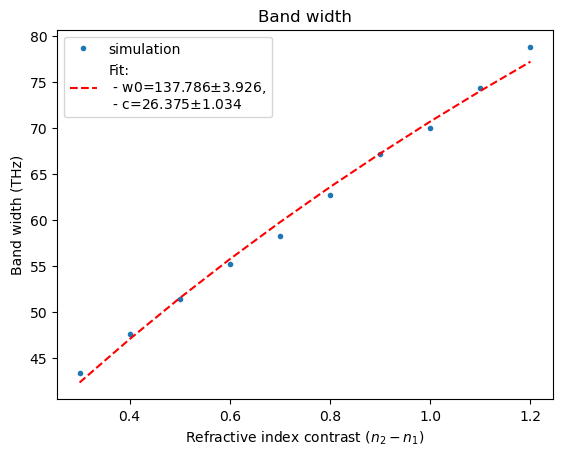

In [13]:
contrast = [ind - n_1 for ind in ref_index]
argument = [(ind - n_1)/(ind + n_1) for ind in ref_index]

popt, pcov = curve_fit(fit_arcsin, argument, band_width, p0=[200,0])
d_w0 = np.sqrt(pcov[0][0])
d_c = np.sqrt(pcov[1][1])

fig, ax = plt.subplots(1, 1)
ax.plot(contrast, band_width, '.', label='simulation')
ax.plot(contrast, fit_arcsin(argument, *popt), 'r--',
        label='Fit:\n - w0=%5.3f$\pm$%5.3f,\n - c=%5.3f$\pm$%5.3f' % tuple([popt[0], d_w0, popt[1], d_c]))

ax.set_title('Band width')
ax.set_xlabel('Refractive index contrast ($n_2 - n_1$)')
ax.set_ylabel('Band width (THz)')

plt.legend()
plt.show()

The attenuated transmission is given by

$T(\omega_0) \approx 4 \left ( \frac{n_1}{n_2} \right )^{2N}$

In [14]:
def fit_attenuation(x, N):
    return 4 * (n_1 / x)**(2*N)

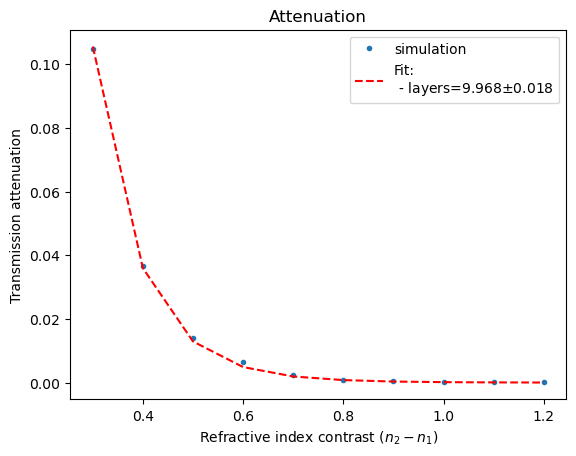

In [15]:
attenuation = np.array(attenuation)
attenuation = 10**(attenuation/10.) # normal intensity

popt, pcov = curve_fit(fit_attenuation, ref_index, attenuation, p0=10)
d_N = np.sqrt(pcov[0][0])

fig, ax = plt.subplots(1, 1)
ax.plot([ind - n_1 for ind in ref_index], attenuation, '.', label='simulation')

fit_att = [fit_attenuation(ind, *popt) for ind in ref_index]
ax.plot(contrast, fit_att, 'r--', label='Fit:\n - layers=%5.3f$\pm$%5.3f' % tuple([popt[0], d_N]))

ax.set_title('Attenuation')
ax.set_xlabel('Refractive index contrast ($n_2 - n_1$)')
ax.set_ylabel('Transmission attenuation')

plt.legend()
plt.show()

## Use the DBR to construct a cavity

In [16]:
plain = True
animation = True

The period of the grating for a wavelenght of 1.55 nm are:
        0.26 um for the n = 1.5 material
        0.15 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000401974 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
time for set_epsilon = 0.168641 s
-----------


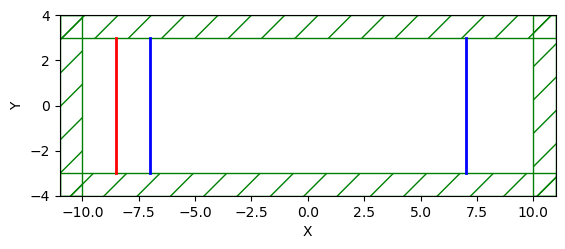

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 80.075/431.0 = 18.6% done in 4.0s, 17.5s to go
on time step 3212 (time=80.3), 0.00124934 s/step
Meep progress: 159.5/431.0 = 37.0% done in 8.0s, 13.6s to go
on time step 6402 (time=160.05), 0.00125753 s/step
Meep progress: 237.60000000000002/431.0 = 55.1% done in 12.0s, 9.8s to go
on time step 9526 (time=238.15), 0.00128141 s/step
Meep progress: 316.82500000000005/431.0 = 73.5% done in 16.0s, 5.8s to go
on time step 12695 (time=317.375), 0.00126225 s/step
Meep progress: 396.0/431.0 = 91.9% done in 20.0s, 1.8s to go
on time step 15862 (time=396.55), 0.00126568 s/step
run 0 finished at t = 431.0 (17240 timesteps)
Beginning of n_1 is at -11.0
End of n_1 is at 11.0
Beginning of -7-th n_2 is at -3.3600000000000003
Beginning of -6-th n_2 is at -2.95
Beginning of -5-th n_2 is at -2.54
Beginning of -4-th n_2 is at -2.13
Beginning of -3-th n_2 is at -1.72
Beginning of -2-th n_2 is at -1.3099999999999998
Beginning of -1-th n_2 is at -0.8999999999999999
Beginning of 0-th n_2 is at 

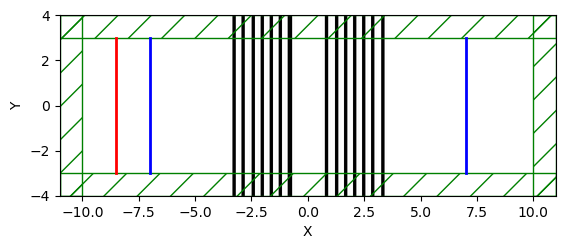

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 73.525/431.0 = 17.1% done in 4.0s, 19.4s to go
on time step 2946 (time=73.65), 0.00135803 s/step
Meep progress: 149.07500000000002/431.0 = 34.6% done in 8.0s, 15.1s to go
on time step 5971 (time=149.275), 0.0013224 s/step
Meep progress: 224.55/431.0 = 52.1% done in 12.0s, 11.0s to go
on time step 8992 (time=224.8), 0.00132415 s/step
Meep progress: 300.3/431.0 = 69.7% done in 16.0s, 7.0s to go
on time step 12012 (time=300.3), 0.00132504 s/step
Meep progress: 376.20000000000005/431.0 = 87.3% done in 20.0s, 2.9s to go
on time step 15048 (time=376.2), 0.0013205 s/step
run 0 finished at t = 431.0 (17240 timesteps)


In [17]:
x_dim = 22
y_dim = 8
PML_thick = 1
resolution = 20

n_1 = 1.5
n_2 = 2.5

layers=14
wavelenght = 1.55
cavity_width = 1.5

grat_period_1 = round(wavelenght / 4 / n_1, 2)
grat_period_2 = round(wavelenght / 4 / n_2, 2)
grat_height = y_dim

print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
        {grat_period_1} um for the n = {n_1} material
        {grat_period_2} um for the n = {n_2} material\n''')

source_width = 6

fcen = 1 / wavelenght
df = 0.5*fcen
nfreq = 5000

sim.reset_meep()
cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

DBL_width = grat_period_2*layers + grat_period_1*(layers-2) + cavity_width

for norma in [False, True]:
    geometry=[]
    if norma:
        sim.reset_meep()
        geometry = [mp.Block(
                        # mp.Vector3(DBL_width, grat_height,0),
                        mp.Vector3(x_dim, y_dim, 0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        print(f'Beginning of n_1 is at {- geometry[0].size.x / 2}')
        print(f'End of n_1 is at {geometry[0].size.x / 2}')
        for ii in range(-int(layers/2), 0):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            # center= mp.Vector3(ii*(grat_period_1+grat_period_2) - cavity_width/2 + grat_period_2/2, 0, 0),
                            center= mp.Vector3(- cavity_width/2 - grat_period_2/2 + (ii+1)*(grat_period_1+grat_period_2), 0, 0),
                            material = mp.Medium(index=n_2))]
            print(f'Beginning of {ii}-th n_2 is at {geometry[-1].center.x - geometry[-1].size.x / 2}')
        for ii in range(0, int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + cavity_width/2 + grat_period_2/2, 0, 0),
                            material = mp.Medium(index=n_2))]
            print(f'Beginning of {ii}-th n_2 is at {(ii)*(grat_period_1+grat_period_2) + cavity_width/2}')

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    if (not plain):
        f = plt.figure(dpi=600)
        animate = mp.Animate2D(sim, mp.Ez, f=f)
        plt.close()

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )
    
    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    freqs = mp.get_flux_freqs(refl)    

    sim.plot2D()
    plt.show()

    if norma:
        sim.load_minus_flux_data(refl, straight_refl_data)
        if (plain):
            sim.run(until_after_sources = 400)
            # sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        else:
            if (animation):
                sim.run(mp.at_every(2, animate),
                        until_after_sources = 400)
                        # until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
                animate.to_mp4(15, './DBRCavity.mp4')
            else:
                sim.run(mp.at_every(2, animate),
                        until_after_sources = 400)
                        # until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
                animate.to_gif(15, './DBRCavity.gif')
    else:
        sim.run(until_after_sources = 400)
        # sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        
    if norma:
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    else:
        straight_refl_data = sim.get_flux_data(refl) # get_flux_data create a binary obj that can't used for inverstigation
        straight_tran_flux = mp.get_fluxes(tran)

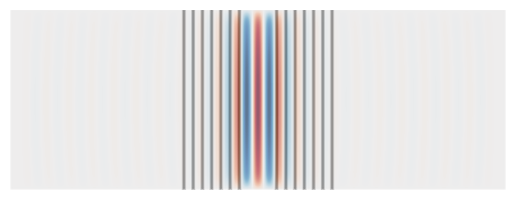

In [18]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)

plt.figure()

plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.6)

plt.axis('off')
plt.show()

Plot the trasmission and reflection due to the DBR.

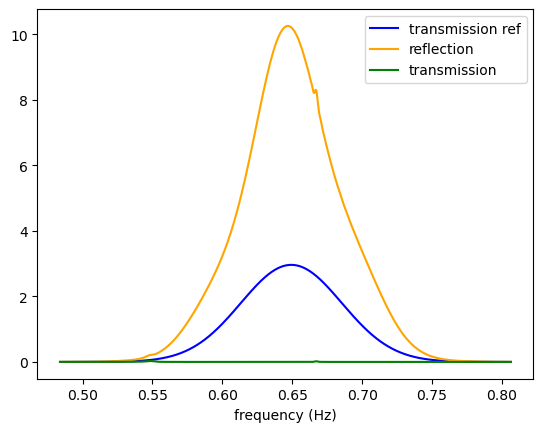

In [19]:
freqs = mp.get_flux_freqs(refl)

plt.figure()

plt.plot(freqs, straight_tran_flux, label='transmission ref', color='blue')
plt.plot(freqs, scatt_refl_flux, label='reflection', color='orange')
plt.plot(freqs, scatt_tran_flux, label='transmission', color='green')

plt.xlabel('frequency (Hz)')

plt.legend(loc="upper right")
plt.show()

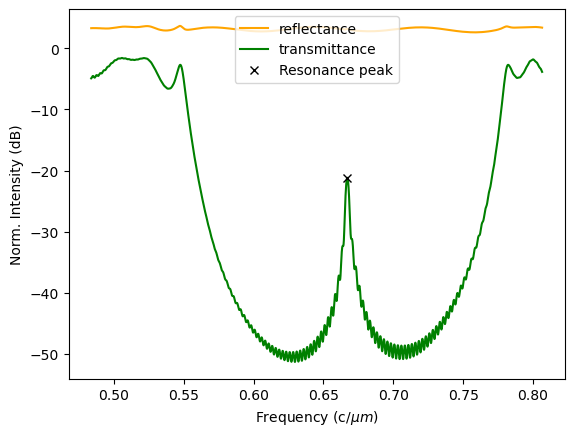

In [20]:
Rs = np.array(scatt_refl_flux)/np.array(straight_tran_flux)
Ts = np.array(scatt_tran_flux)/np.array(straight_tran_flux)
Ts = 10*np.log10(Ts) # in dB

peak_T, _ = find_peaks(Ts, prominence=5)

plt.plot(freqs, Rs, label='reflectance', color='orange')
plt.plot(freqs, Ts, label='transmittance', color='green')
# plt.plot(freqs, 1-Rs-Ts, label='loss', color='violet')

for pp in peak_T:
    plt.plot(freqs[pp], Ts[pp], "x", color='black', label='Resonance peak')

plt.xlabel('Frequency (c/$\mu m$)')
plt.ylabel('Norm. Intensity (dB)')

# plt.yscale("log") # when is isn't in dB 

plt.legend(loc='upper center')
plt.show()

Find the Q factor of the cavity

In [21]:
def fit_lorentzian (xx, A, gamma, x0, c):
    return  A/math.pi * gamma/2 / ((xx - x0)**2 + (gamma/2)**2) + c

In [22]:
freqs = np.array(freqs)

freq_low = freqs[np.where(freqs>=0.63)[0]]
freq_cut = freq_low[np.where(freq_low <= 0.70)[0]]

Ts_low = Ts[np.where(freqs>=0.63)[0]]
Ts_cut = Ts_low[np.where(freq_low <= 0.70)[0]]


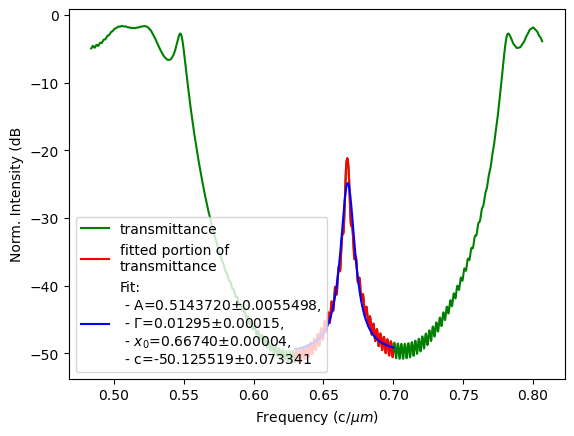

The Q-factor of the cavity is 51.543405069874865


In [23]:
popt, pcov = curve_fit(fit_lorentzian, freq_cut, Ts_cut, p0=[0.01, 0.1, freqs[peak_T[0]], 0], 
                       bounds=[[0, 0, 0, -np.inf], np.inf])
d_A = np.sqrt(pcov[0][0])
d_gamma = np.sqrt(pcov[1][1])
d_x0 = np.sqrt(pcov[2][2])
d_c = np.sqrt(pcov[3][3])

plt.plot(freqs, Ts, label='transmittance', color='green')
plt.plot(freq_cut, Ts_cut, label='fitted portion of\ntransmittance', color='red')
plt.plot(freq_cut, fit_lorentzian(freq_cut, *popt), color='blue',
         label='Fit:\n - A=%5.7f$\pm$%5.7f,\n - $\Gamma$=%5.5f$\pm$%5.5f,\n - $x_0$=%5.5f$\pm$%5.5f,\n - c=%5.6f$\pm$%5.6f' 
         % tuple([popt[0], d_A, popt[1], d_gamma, popt[2], d_x0, popt[3], d_c]))

plt.xlabel('Frequency (c/$\mu m$)')
plt.ylabel('Norm. Intensity (dB')

plt.legend(loc='lower left')
plt.show()

print(f'The Q-factor of the cavity is {popt[2]/popt[1]}')

### Spectrum of DBR with the cavity against the one without cavity!

-----------
Initializing structure...
time for choose_chunkdivision = 0.000334978 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
time for set_epsilon = 0.138687 s
-----------


FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 80.35000000000001/431.0 = 18.6% done in 4.0s, 17.5s to go
on time step 3230 (time=80.75), 0.00123872 s/step
Meep progress: 161.47500000000002/431.0 = 37.5% done in 8.0s, 13.4s to go
on time step 6468 (time=161.7), 0.00123695 s/step
Meep progress: 242.55/431.0 = 56.3% done in 12.0s, 9.3s to go
on time step 9714 (time=242.85), 0.00123254 s/step
Meep progress: 322.45000000000005/431.0 = 74.8% done in 16.0s, 5.4s to go
on time step 12914 (time=322.85), 0.00125417 s/step
Meep progress: 401.5/431.0 = 93.2% done in 20.0s, 1.5s to go
on time step 16079 (time=401.975), 0.00126385 s/step
run 0 finished at t = 431.0 (17240 timesteps)
The period of the grating for a wavelenght of 1.55 nm are:
        0.26 um for the n = 1.5 material
        0.15 um for the n = 2.5 material

     block, center = (0,0,0)
          size (5.74,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.795,0,0)
          size (

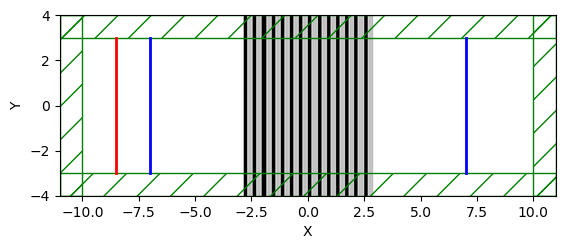

-----------
Initializing structure...
time for choose_chunkdivision = 0.000534058 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (5.74,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-2.795,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.385,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.975,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-1.565,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     blo

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 75.75/431.0 = 17.6% done in 4.0s, 18.8s to go
on time step 3036 (time=75.9), 0.00132225 s/step
Meep progress: 152.35/431.0 = 35.3% done in 8.0s, 14.6s to go
on time step 6116 (time=152.9), 0.00130164 s/step
Meep progress: 229.35000000000002/431.0 = 53.2% done in 12.0s, 10.6s to go
on time step 9196 (time=229.9), 0.00130259 s/step
Meep progress: 300.05/431.0 = 69.6% done in 16.0s, 7.0s to go
on time step 12022 (time=300.55), 0.0014158 s/step
Meep progress: 376.07500000000005/431.0 = 87.3% done in 20.0s, 2.9s to go
on time step 15070 (time=376.75), 0.0013152 s/step
run 0 finished at t = 431.0 (17240 timesteps)
     block, center = (0,0,0)
          size (6.72,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.285,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.875,0,0)
      

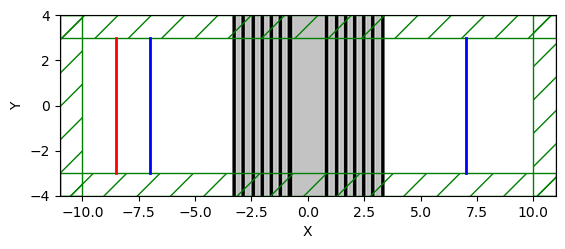

-----------
Initializing structure...
time for choose_chunkdivision = 0.000533104 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (6.72,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.285,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.875,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.465,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.055,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     blo

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 75.35000000000001/431.0 = 17.5% done in 4.0s, 18.9s to go
on time step 3017 (time=75.425), 0.00132588 s/step
Meep progress: 153.45000000000002/431.0 = 35.6% done in 8.0s, 14.5s to go
on time step 6138 (time=153.45), 0.00128188 s/step
Meep progress: 231.0/431.0 = 53.6% done in 12.0s, 10.4s to go
on time step 9240 (time=231), 0.00129071 s/step
Meep progress: 308.55/431.0 = 71.6% done in 16.0s, 6.4s to go
on time step 12342 (time=308.55), 0.00129043 s/step
Meep progress: 386.65000000000003/431.0 = 89.7% done in 20.0s, 2.3s to go
on time step 15466 (time=386.65), 0.0012828 s/step
run 0 finished at t = 431.0 (17240 timesteps)


In [24]:
freq_comparison = []
Ts_comparison = []

resolution = 20
n_1 = 1.5
n_2 = 2.5
layers=14

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

geometry=[]
source = [mp.Source(
    mp.GaussianSource(fcen,fwidth=df),
    center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
    component=mp.Ez,
    size=mp.Vector3(0,source_width,0)
    )]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    resolution=resolution
)

# monitor
trans_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
            )
refl_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
            )

tran = sim.add_flux(fcen, df, nfreq, trans_fr)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
freqs = mp.get_flux_freqs(refl)    

sim.run(until_after_sources = 400)
# sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))

straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

grat_period_1 = round(wavelenght / 4 / n_1, 2)
grat_period_2 = round(wavelenght / 4 / n_2, 2)
DBL_width = grat_period_2*layers + grat_period_1*(layers-2) + cavity_width

print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
        {grat_period_1} um for the n = {n_1} material
        {grat_period_2} um for the n = {n_2} material\n''')

for cavity in [False, True]:
    sim.reset_meep()
    geometry = []
    if(cavity):
        geometry = [mp.Block(
                        mp.Vector3(DBL_width, grat_height,0),
                        # mp.Vector3(x_dim, y_dim, 0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        for ii in range(-int(layers/2), 0):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            # center= mp.Vector3(ii*(grat_period_1+grat_period_2) - cavity_width/2 + grat_period_2/2, 0, 0),
                            center= mp.Vector3(- cavity_width/2 - grat_period_2/2 + (ii+1)*(grat_period_1+grat_period_2), 0, 0),
                            material = mp.Medium(index=n_2))]
        for ii in range(0, int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + cavity_width/2 + grat_period_2/2, 0, 0),
                            material = mp.Medium(index=n_2))]
    else:
        geometry = [mp.Block(
                        mp.Vector3((grat_period_1 + grat_period_2)*layers, grat_height,0),
                        center = mp.Vector3(0,0,0),
                        material = mp.Medium(index=n_1)),
                    ]
        for ii in range(-int(layers/2), int(layers/2)):
            geometry += [mp.Block(
                            mp.Vector3(grat_period_2, grat_height, 0),
                            center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + grat_period_2/2, 0, 0),
                            material = mp.Medium(index=n_2))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    sim.plot2D()
    plt.show()

    sim.load_minus_flux_data(refl, straight_refl_data)
    sim.run(until_after_sources = 400)
    # sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        
    scatt_refl_flux = mp.get_fluxes(refl)
    scatt_tran_flux = mp.get_fluxes(tran)
    freqs = mp.get_flux_freqs(refl)    

    Ts = np.array(scatt_tran_flux)/np.array(straight_tran_flux)
    Ts = 10*np.log10(Ts) # in dB
    
    freq_comparison += [freqs]
    Ts_comparison += [Ts]

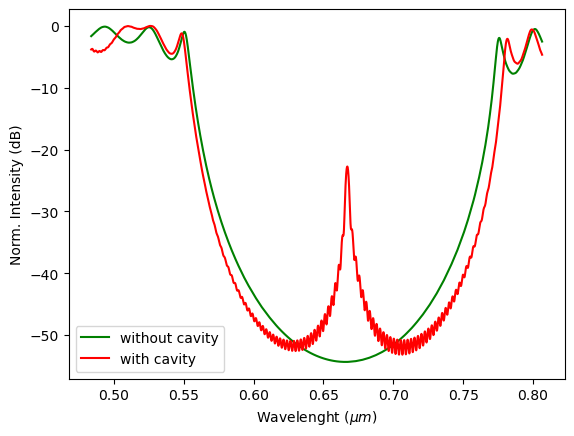

In [25]:
plt.plot(freq_comparison[0], Ts_comparison[0], label='without cavity', color='green')
plt.plot(freq_comparison[1], Ts_comparison[1], label='with cavity', color='red')

plt.xlabel('Wavelenght ($\mu m$)')
plt.ylabel('Norm. Intensity (dB)')

plt.legend()
plt.show()

## Dependence of the DBR cavity from the index contrast

-----------
Initializing structure...
time for choose_chunkdivision = 0.000370026 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
time for set_epsilon = 0.166406 s
-----------


FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 79.2/431.0 = 18.4% done in 4.0s, 17.8s to go
on time step 3168 (time=79.2), 0.001264 s/step
Meep progress: 160.05/431.0 = 37.1% done in 8.0s, 13.6s to go
on time step 6402 (time=160.05), 0.00123878 s/step
Meep progress: 241.775/431.0 = 56.1% done in 12.0s, 9.4s to go
on time step 9673 (time=241.825), 0.00122295 s/step
Meep progress: 323.95000000000005/431.0 = 75.2% done in 16.0s, 5.3s to go
on time step 12958 (time=323.95), 0.00122076 s/step
Meep progress: 404.8/431.0 = 93.9% done in 20.0s, 1.3s to go
on time step 16193 (time=404.825), 0.00123666 s/step
run 0 finished at t = 431.0 (17240 timesteps)
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.19 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000529051 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 76.45/431.0 = 17.7% done in 4.0s, 18.6s to go
on time step 3058 (time=76.45), 0.00130934 s/step
Meep progress: 154.0/431.0 = 35.7% done in 8.0s, 14.4s to go
on time step 6160 (time=154), 0.00129168 s/step
Meep progress: 232.10000000000002/431.0 = 53.9% done in 12.0s, 10.3s to go
on time step 9284 (time=232.1), 0.00128377 s/step
Meep progress: 308.375/431.0 = 71.5% done in 16.0s, 6.4s to go
on time step 12336 (time=308.4), 0.00131084 s/step
Meep progress: 383.90000000000003/431.0 = 89.1% done in 20.0s, 2.5s to go
on time step 15356 (time=383.9), 0.00132626 s/step
run 0 finished at t = 431.0 (17240 timesteps)


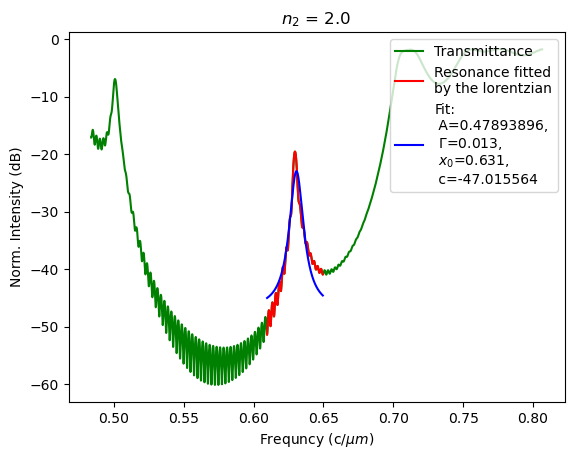

The Q-factor of the cavity is 49.7723530645705
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.18 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000533104 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.48,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-3.04,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.6,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 78.10000000000001/431.0 = 18.1% done in 4.0s, 18.1s to go
on time step 3124 (time=78.1), 0.00128265 s/step
Meep progress: 156.20000000000002/431.0 = 36.2% done in 8.0s, 14.1s to go
on time step 6248 (time=156.2), 0.00128213 s/step
Meep progress: 234.85000000000002/431.0 = 54.5% done in 12.0s, 10.0s to go
on time step 9394 (time=234.85), 0.00127475 s/step
Meep progress: 312.925/431.0 = 72.6% done in 16.0s, 6.0s to go
on time step 12518 (time=312.95), 0.00128481 s/step
Meep progress: 389.975/431.0 = 90.5% done in 20.0s, 2.1s to go
on time step 15620 (time=390.5), 0.00129466 s/step
run 0 finished at t = 431.0 (17240 timesteps)


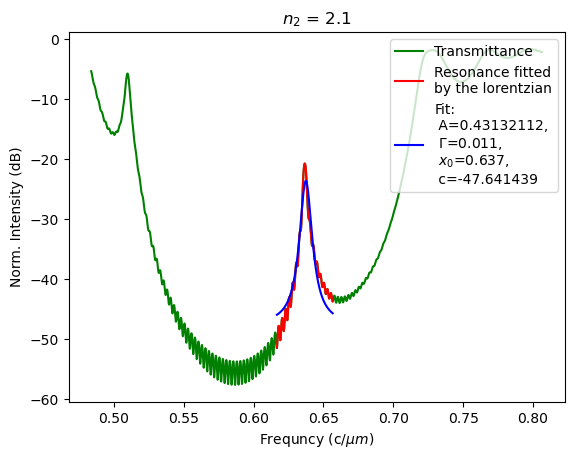

The Q-factor of the cavity is 55.752598178116834
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.18 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000541925 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.48,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-3.04,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.6,0,0)
          size (0.18,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal =

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 76.97500000000001/431.0 = 17.9% done in 4.0s, 18.4s to go
on time step 3080 (time=77), 0.00130189 s/step
Meep progress: 154.75/431.0 = 35.9% done in 8.0s, 14.3s to go
on time step 6204 (time=155.1), 0.00128331 s/step
Meep progress: 232.10000000000002/431.0 = 53.9% done in 12.0s, 10.3s to go
on time step 9306 (time=232.65), 0.00129292 s/step
Meep progress: 308.55/431.0 = 71.6% done in 16.0s, 6.4s to go
on time step 12361 (time=309.025), 0.00130952 s/step
Meep progress: 385.0/431.0 = 89.3% done in 20.0s, 2.4s to go
on time step 15414 (time=385.35), 0.00131036 s/step
run 0 finished at t = 431.0 (17240 timesteps)


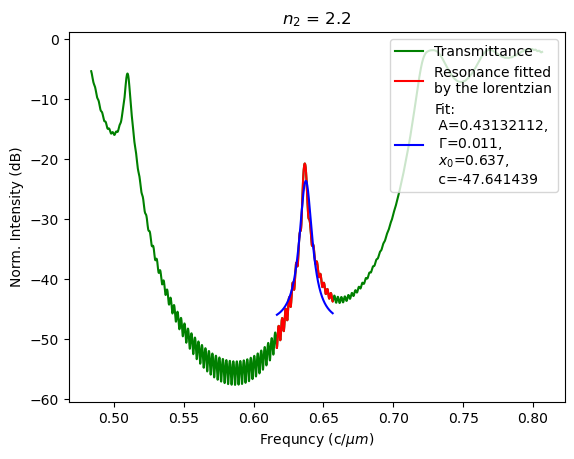

The Q-factor of the cavity is 55.752598178116834
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.17 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000540972 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.415,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.985,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.555,0,0)
          size (0.17,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagon

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 77.55000000000001/431.0 = 18.0% done in 4.0s, 18.3s to go
on time step 3102 (time=77.55), 0.00129214 s/step
Meep progress: 152.9/431.0 = 35.5% done in 8.0s, 14.6s to go
on time step 6116 (time=152.9), 0.00132806 s/step
Meep progress: 228.65/431.0 = 53.1% done in 12.0s, 10.6s to go
on time step 9148 (time=228.7), 0.00131937 s/step
Meep progress: 305.725/431.0 = 70.9% done in 16.0s, 6.6s to go
on time step 12232 (time=305.8), 0.00130098 s/step
Meep progress: 387.20000000000005/431.0 = 89.8% done in 20.0s, 2.3s to go
on time step 15498 (time=387.45), 0.0012248 s/step
run 0 finished at t = 431.0 (17240 timesteps)


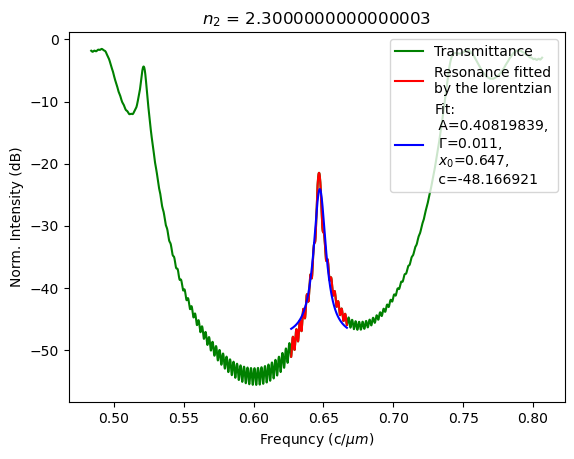

The Q-factor of the cavity is 59.968865791736896
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.16 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000499964 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.35,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.93,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.51,0,0)
          size (0.16,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal 

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 70.45/431.0 = 16.3% done in 4.0s, 20.5s to go
on time step 2822 (time=70.55), 0.00141752 s/step
Meep progress: 136.07500000000002/431.0 = 31.6% done in 8.0s, 17.3s to go
on time step 5450 (time=136.25), 0.0015225 s/step
Meep progress: 202.95000000000002/431.0 = 47.1% done in 12.0s, 13.5s to go
on time step 8123 (time=203.075), 0.00149649 s/step
Meep progress: 270.6/431.0 = 62.8% done in 16.0s, 9.5s to go
on time step 10824 (time=270.6), 0.00148196 s/step
Meep progress: 338.82500000000005/431.0 = 78.6% done in 20.0s, 5.4s to go
on time step 13554 (time=338.85), 0.00146544 s/step
Meep progress: 407.52500000000003/431.0 = 94.6% done in 24.0s, 1.4s to go
on time step 16302 (time=407.55), 0.00146012 s/step
run 0 finished at t = 431.0 (17240 timesteps)


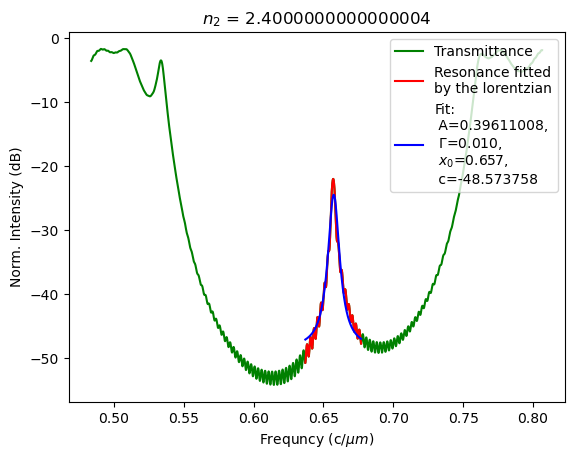

The Q-factor of the cavity is 62.90710500318414
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.15 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000660896 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.285,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.875,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.465,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagona

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 65.2/431.0 = 15.1% done in 4.0s, 22.4s to go
on time step 2618 (time=65.45), 0.00153257 s/step
Meep progress: 129.225/431.0 = 30.0% done in 8.0s, 18.7s to go
on time step 5180 (time=129.5), 0.00156149 s/step
Meep progress: 196.525/431.0 = 45.6% done in 12.0s, 14.3s to go
on time step 7876 (time=196.9), 0.00148587 s/step
Meep progress: 263.45/431.0 = 61.1% done in 16.0s, 10.2s to go
on time step 10560 (time=264), 0.00149494 s/step
Meep progress: 328.5/431.0 = 76.2% done in 20.0s, 6.2s to go
on time step 13162 (time=329.05), 0.00153729 s/step
Meep progress: 394.90000000000003/431.0 = 91.6% done in 24.0s, 2.2s to go
on time step 15818 (time=395.45), 0.0015089 s/step
run 0 finished at t = 431.0 (17240 timesteps)


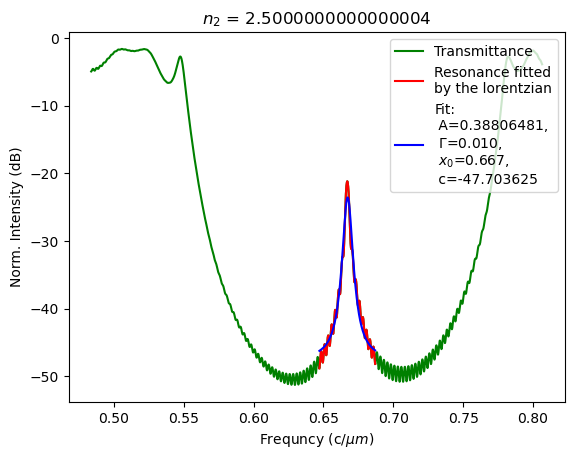

The Q-factor of the cavity is 65.21446189223553
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.15 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000538111 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.285,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.875,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.465,0,0)
          size (0.15,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagona

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 65.825/431.0 = 15.3% done in 4.0s, 22.2s to go
on time step 2640 (time=66), 0.00151999 s/step
Meep progress: 133.775/431.0 = 31.0% done in 8.0s, 17.8s to go
on time step 5368 (time=134.2), 0.00147165 s/step
Meep progress: 198.0/431.0 = 45.9% done in 12.0s, 14.1s to go
on time step 7935 (time=198.375), 0.0015585 s/step
Meep progress: 263.675/431.0 = 61.2% done in 16.0s, 10.2s to go
on time step 10560 (time=264), 0.0015253 s/step
Meep progress: 334.925/431.0 = 77.7% done in 20.0s, 5.7s to go
on time step 13409 (time=335.225), 0.00140405 s/step
Meep progress: 407.0/431.0 = 94.4% done in 24.0s, 1.4s to go
on time step 16302 (time=407.55), 0.00138668 s/step
run 0 finished at t = 431.0 (17240 timesteps)


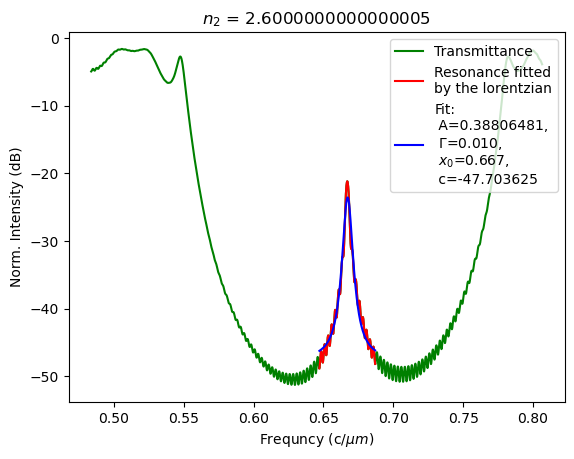

The Q-factor of the cavity is 65.21446189223553
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.14 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000549078 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.22,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.82,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.42,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal =

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 68.2/431.0 = 15.8% done in 4.0s, 21.3s to go
on time step 2728 (time=68.2), 0.00146739 s/step
Meep progress: 138.875/431.0 = 32.2% done in 8.0s, 16.8s to go
on time step 5557 (time=138.925), 0.00141399 s/step
Meep progress: 208.45000000000002/431.0 = 48.4% done in 12.0s, 12.8s to go
on time step 8338 (time=208.45), 0.00144178 s/step
Meep progress: 278.075/431.0 = 64.5% done in 16.0s, 8.8s to go
on time step 11124 (time=278.1), 0.00143605 s/step
Meep progress: 348.625/431.0 = 80.9% done in 20.0s, 4.7s to go
on time step 13948 (time=348.7), 0.00142115 s/step
Meep progress: 418.0/431.0 = 97.0% done in 24.0s, 0.7s to go
on time step 16728 (time=418.2), 0.00143934 s/step
run 0 finished at t = 431.0 (17240 timesteps)


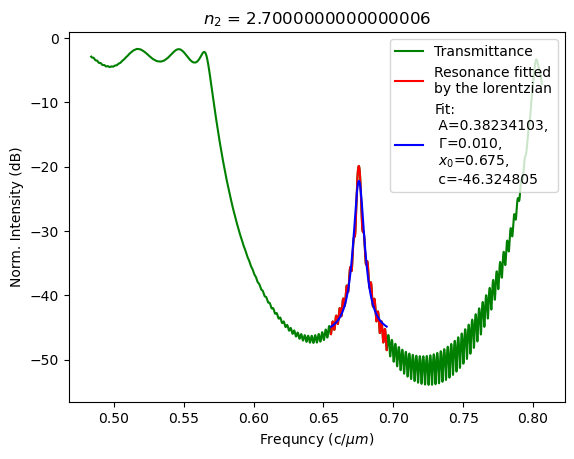

The Q-factor of the cavity is 66.85346298282558
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.14 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000537872 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.22,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.82,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.42,0,0)
          size (0.14,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal =

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 70.8/431.0 = 16.4% done in 4.0s, 20.4s to go
on time step 2838 (time=70.95), 0.00141156 s/step
Meep progress: 141.05/431.0 = 32.7% done in 8.0s, 16.4s to go
on time step 5654 (time=141.35), 0.00142244 s/step
Meep progress: 211.72500000000002/431.0 = 49.1% done in 12.0s, 12.4s to go
on time step 8480 (time=212), 0.00141556 s/step
Meep progress: 283.25/431.0 = 65.7% done in 16.0s, 8.3s to go
on time step 11352 (time=283.8), 0.00139683 s/step
Meep progress: 355.85/431.0 = 82.6% done in 20.0s, 4.2s to go
on time step 14256 (time=356.4), 0.00138173 s/step
Meep progress: 428.07500000000005/431.0 = 99.3% done in 24.0s, 0.2s to go
on time step 17157 (time=428.925), 0.00137902 s/step
run 0 finished at t = 431.0 (17240 timesteps)


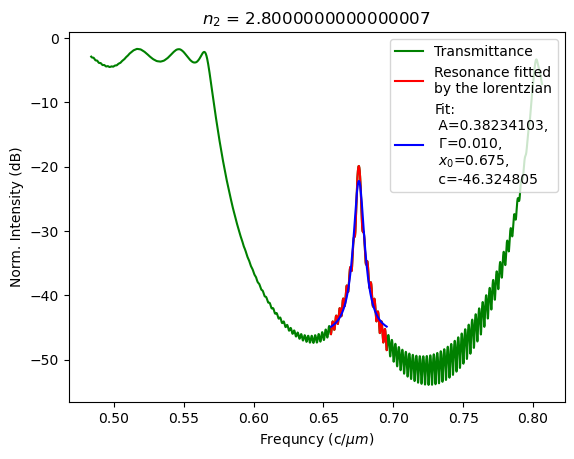

The Q-factor of the cavity is 66.85346298282558
The period of the grating for a wavelenght of 1.55 nm are:
            0.26 um for the n = 1.5 material
            0.13 um for the n = 2.5 material

-----------
Initializing structure...
time for choose_chunkdivision = 0.000566006 s
Working in 2D dimensions.
Computational cell is 22 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (22,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-3.155,0,0)
          size (0.13,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.765,0,0)
          size (0.13,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-2.375,0,0)
          size (0.13,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagona

FloatProgress(value=0.0, description='0% done ', max=431.0)

Meep progress: 72.05/431.0 = 16.7% done in 4.0s, 20.0s to go
on time step 2882 (time=72.05), 0.00138828 s/step
Meep progress: 145.75/431.0 = 33.8% done in 8.0s, 15.7s to go
on time step 5834 (time=145.85), 0.00135523 s/step
Meep progress: 218.07500000000002/431.0 = 50.6% done in 12.0s, 11.7s to go
on time step 8730 (time=218.25), 0.00138129 s/step
Meep progress: 290.625/431.0 = 67.4% done in 16.0s, 7.7s to go
on time step 11633 (time=290.825), 0.00137808 s/step
Meep progress: 363.55/431.0 = 84.4% done in 20.0s, 3.7s to go
on time step 14542 (time=363.55), 0.00137538 s/step
run 0 finished at t = 431.0 (17240 timesteps)


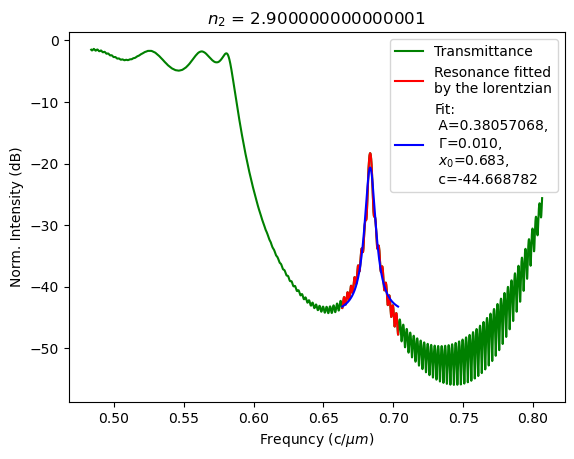

The Q-factor of the cavity is 67.75219223080963


In [26]:
ref_index = []
Q_factor = []

plot=True

resolution = 20
n_1 = 1.5
layers=14

cell = mp.Vector3(x_dim, y_dim, 0)
pml_layers = [mp.PML(PML_thick)]

geometry=[]
source = [mp.Source(
    mp.GaussianSource(fcen,fwidth=df),
    center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
    component=mp.Ez,
    size=mp.Vector3(0,source_width,0)
    )]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    resolution=resolution
)

# monitor
trans_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
            )
refl_fr = mp.FluxRegion(
                size=mp.Vector3(0,source_width, 0),
                center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
            )

tran = sim.add_flux(fcen, df, nfreq, trans_fr)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

sim.run(until_after_sources = 400)
# sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))

straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

for ind in np.arange(2, 3, 0.1):
    grat_period_1 = round(wavelenght / 4 / n_1, 2)
    grat_period_2 = round(wavelenght / 4 / ind, 2)
    DBL_width = grat_period_2*layers + grat_period_1*(layers-2) + cavity_width
    
    print(f'''The period of the grating for a wavelenght of {wavelenght} nm are:
            {grat_period_1} um for the n = {n_1} material
            {grat_period_2} um for the n = {n_2} material\n''')

    sim.reset_meep()
    geometry = [mp.Block(
                    # mp.Vector3(DBL_width, grat_height,0),
                    mp.Vector3(x_dim, y_dim, 0),
                    center = mp.Vector3(0,0,0),
                    material = mp.Medium(index=n_1)),
                ]
    for ii in range(-int(layers/2), 0):
        geometry += [mp.Block(
                        mp.Vector3(grat_period_2, grat_height, 0),
                        # center= mp.Vector3(ii*(grat_period_1+grat_period_2) - cavity_width/2 + grat_period_2/2, 0, 0),
                        center= mp.Vector3(- cavity_width/2 - grat_period_2/2 + (ii+1)*(grat_period_1+grat_period_2), 0, 0),
                        material = mp.Medium(index=n_2))]
    for ii in range(0, int(layers/2)):
        geometry += [mp.Block(
                        mp.Vector3(grat_period_2, grat_height, 0),
                        center= mp.Vector3((ii)*(grat_period_1+grat_period_2) + cavity_width/2 + grat_period_2/2, 0, 0),
                        material = mp.Medium(index=n_2))]

    source = [mp.Source(
                mp.GaussianSource(fcen,fwidth=df),
                center=mp.Vector3(-x_dim/2 + PML_thick + 1.5, 0, 0),
                component=mp.Ez,
                size=mp.Vector3(0,source_width,0)
            )]

    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        resolution=resolution
    )

    # monitor
    trans_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(x_dim/2 - PML_thick - 3, 0, 0),
                )
    refl_fr = mp.FluxRegion(
                    size=mp.Vector3(0,source_width, 0),
                    center=mp.Vector3(-x_dim/2 + PML_thick + 3, 0, 0),
                )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)
    freqs = mp.get_flux_freqs(refl)    

    # sim.plot2D()
    # plt.show()

    sim.load_minus_flux_data(refl, straight_refl_data)
    sim.run(until_after_sources = 400)
    # sim.run(until_after_sources = mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(0.,0.,0.), 1e-3))
        
    scatt_refl_flux = mp.get_fluxes(refl)
    scatt_tran_flux = mp.get_fluxes(tran)
    
    Ts = np.array(scatt_tran_flux)/np.array(straight_tran_flux)
    Ts = 10*np.log10(Ts) # in dB

    peak_T, _ = find_peaks(Ts, prominence=15)

    freqs = np.array(freqs)
    margin = 0.02
    freq_low = freqs[np.where(freqs>=freqs[peak_T][0]-margin)[0]]
    freq_cut = freq_low[np.where(freq_low <= freqs[peak_T][0]+margin)[0]]

    Ts_low = Ts[np.where(freqs>=freqs[peak_T][0]-margin)[0]]
    Ts_cut = Ts_low[np.where(freq_low <= freqs[peak_T][0]+margin)[0]]

    popt, _ = curve_fit(fit_lorentzian, freq_cut, Ts_cut, p0=[1, 0.01, freqs[peak_T][0], -40], 
                        bounds=[[0, 0, 0, -np.inf], np.inf])

    if (plot):
        plt.plot(freqs, Ts, label='Transmittance', color='green')
        plt.plot(freq_cut, Ts_cut, label='Resonance fitted\nby the lorentzian', color='red')
        plt.plot(freq_cut, fit_lorentzian(freq_cut, *popt), color='blue',
                 label='Fit:\n A=%5.8f,\n $\Gamma$=%5.3f,\n $x_0$=%5.3f,\n c=%5.6f' % tuple(popt))

        plt.xlabel('Frequncy (c/$\mu m$)')
        plt.ylabel('Norm. Intensity (dB)')

        # plt.yscale("log")

        plt.title(f'$n_2$ = {ind}')
        plt.legend(loc='upper right')
        plt.show()

    print(f'The Q-factor of the cavity is {popt[2]/popt[1]}')

    ref_index += [ind]
    Q_factor += [popt[2]/popt[1]]

As the contrast between the refractive indexes incresases the two mirrors (DBR) become even more reflective, improving this way the cavity and its quality factor.

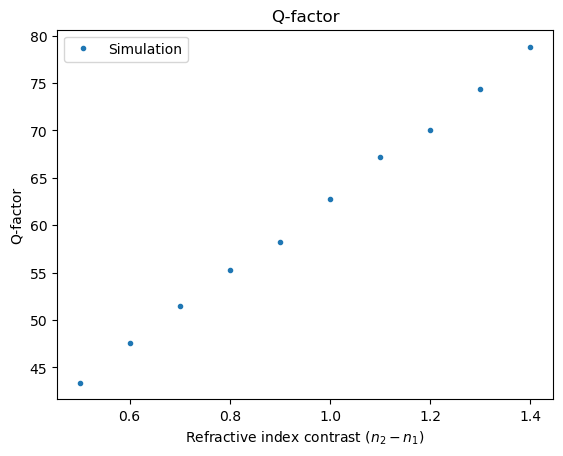

In [27]:
contrast = [ind - n_1 for ind in ref_index]

fig, ax = plt.subplots(1, 1)
ax.plot(contrast, band_width, '.', label='Simulation')

ax.set_title('Q-factor')
ax.set_xlabel('Refractive index contrast ($n_2 - n_1$)')
ax.set_ylabel('Q-factor')

plt.legend()
plt.show()